In [72]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import functions
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.image as mpimg

In [73]:
# IMPORT REPORTING DATA
df_reporting = pd.read_csv('data/SB-County-County Public reporting 2020-01-01_2024-12-31.csv')
# print(df_reporting.head())

In [74]:
df_reporting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Day                                  1827 non-null   object 
 1   Started Sessions                     1827 non-null   int64  
 2   Completed Sessions                   1827 non-null   int64  
 3   Microsessions                        1827 non-null   int64  
 4   AVG session duration (minutes)       1824 non-null   float64
 5   AVG charging duration (minutes)      1827 non-null   float64
 6   AVG session idle (minutes)           1824 non-null   float64
 7   Energy delivered (kWh)               1827 non-null   float64
 8   AVG kWh delivered per session (kWh)  1827 non-null   float64
 9   Max kWh delivered per session (kWh)  1827 non-null   float64
 10  Max kW hour (kW)                     1827 non-null   object 
 11  GHGs avoided (lbs)            

## Data Preparation

### Santa Barbara County Reporting Data

In [75]:
print(f"The dataframe has {df_reporting.shape[0]} and {df_reporting.shape[1]} columns")

The dataframe has 1827 and 22 columns


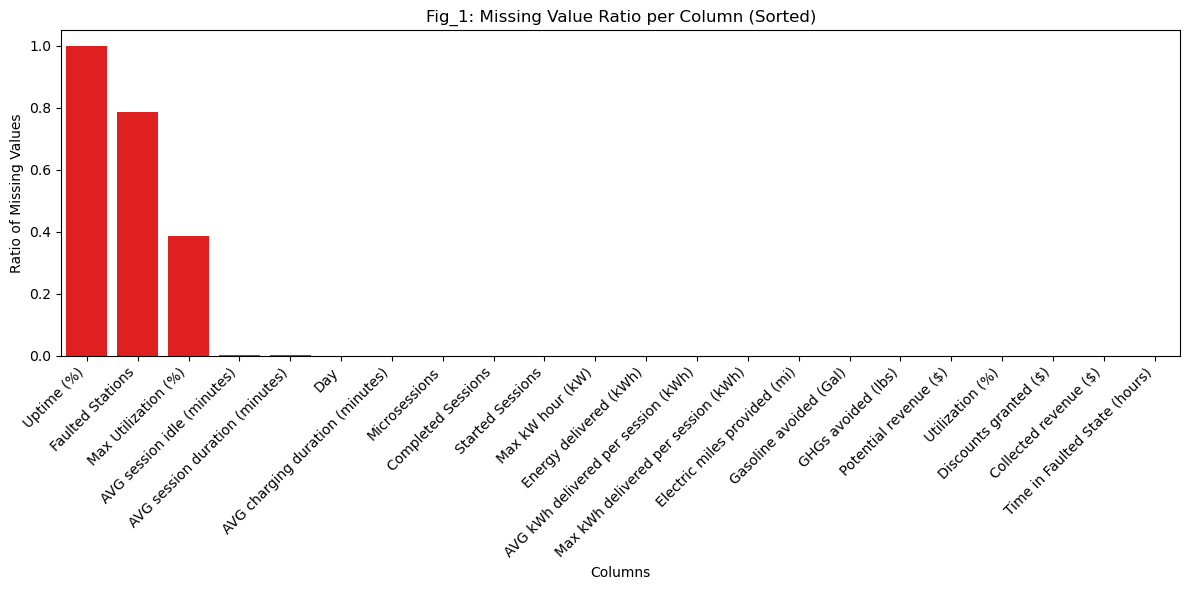

In [76]:
# Gets the mean of missing values in each column. Since True = 1 and False = 0 the mean tells us how much of the data is missing. 
# Sinde the value "-" was we are first replacing it for np.nan and then checking for the missing values.
df_reporting_w_missing_values = df_reporting.replace("-", np.nan).isnull().mean().sort_values(ascending=False)

# Create the bar plot with Seaborn
plt.figure(figsize=(12, 6))
fig1 = sns.barplot(x=df_reporting_w_missing_values.index, y=df_reporting_w_missing_values.values, color='red')

# Customize the plot
plt.xlabel('Columns')
plt.ylabel('Ratio of Missing Values')
plt.title('Fig_1: Missing Value Ratio per Column (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
plt.savefig('images/days/fig1.jpg')

# Show the plot
plt.show()

#### Feature Values Issue Max kW hour (kW) 
There appears to be an error in the computation or logging of this feature as it strangely reports that the Max kW hour is 1am each day which cannot possible be true. For this reason we are removing this feature from the dataset.

In [77]:
df_reporting = df_reporting.drop(["Max kW hour (kW)"], axis=1)

#### Known Feature Change

The CSB representative informed us that the Max Utilization (%), Faulted Stations, and Uptime (%) features were introduced gradually over time and in full starting in December 2023. For this reason they will be revied separately, but will not be included in the forecast model dataset. I will however produce a separate dataframe that includes that feature since CSB was interested in a visualization report for these features.

In [78]:
# Partition the dataset at index 1462 wich corresponds to January 1st 2024
df_reporting_2024 = df_reporting.iloc[1462:].copy()

In [79]:
df_reporting = df_reporting.drop(["Max Utilization (%)","Faulted Stations", "Uptime (%)"], axis=1)

In [80]:
# given that there's a very small fraction of missing values for 
# 'AVG session duration (minutes)' and 'AVG session idle (minutes)' we are going to inpute the mean values.

# Calculate mean values
avg_session_duration_mean = df_reporting['AVG session duration (minutes)'].mean()
avg_session_idle_mean = df_reporting['AVG session idle (minutes)'].mean()

# Impute missing values with calculated means
df_reporting['AVG session duration (minutes)'] = df_reporting['AVG session duration (minutes)'].fillna(avg_session_duration_mean)
df_reporting['AVG session idle (minutes)'] = df_reporting['AVG session idle (minutes)'].fillna(avg_session_idle_mean)

## Statistical Analysis

In [81]:
# Basic Statistical Analysis
df_reporting.describe()

,Started Sessions,Completed Sessions,Microsessions,AVG session duration (minutes),AVG charging duration (minutes),AVG session idle (minutes),Energy delivered (kWh),AVG kWh delivered per session (kWh),Max kWh delivered per session (kWh),GHGs avoided (lbs),Gasoline avoided (Gal),Electric miles provided (mi),Potential revenue ($),Collected revenue ($),Discounts granted ($),Utilization (%),Time in Faulted State (hours)
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,38.035577,38.015326,7.714286,430.648254,65.535201,365.176641,420.544415,7.202200,34.273717,657.054293,33.536607,748.843787,623.060014,72.012009,551.048005,25.473887,3.915304
std,38.874096,38.841588,9.927195,773.758001,71.896229,736.864125,490.539112,6.109697,29.276913,766.413290,39.118383,873.480071,1521.984850,190.314241,1461.207298,23.287302,30.175529
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-44.942610,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.000000,32.000000,5.000000,107.767262,54.816212,41.921805,264.989400,8.498185,40.905310,414.016728,21.131764,471.854241,52.965930,46.163258,0.000000,29.291667,0.000000
75%,66.000000,65.000000,11.000000,582.976821,118.822587,463.613857,683.256450,12.183712,57.018248,1067.512888,54.486761,1216.642829,448.202545,111.971010,335.576107,49.395833,0.000000
max,163.000000,167.000000,73.000000,9459.314257,1439.666691,9254.571535,2270.513200,54.358002,119.160000,3547.426598,181.063655,4042.996746,23175.898000,6199.111000,22903.167320,58.875000,576.430000


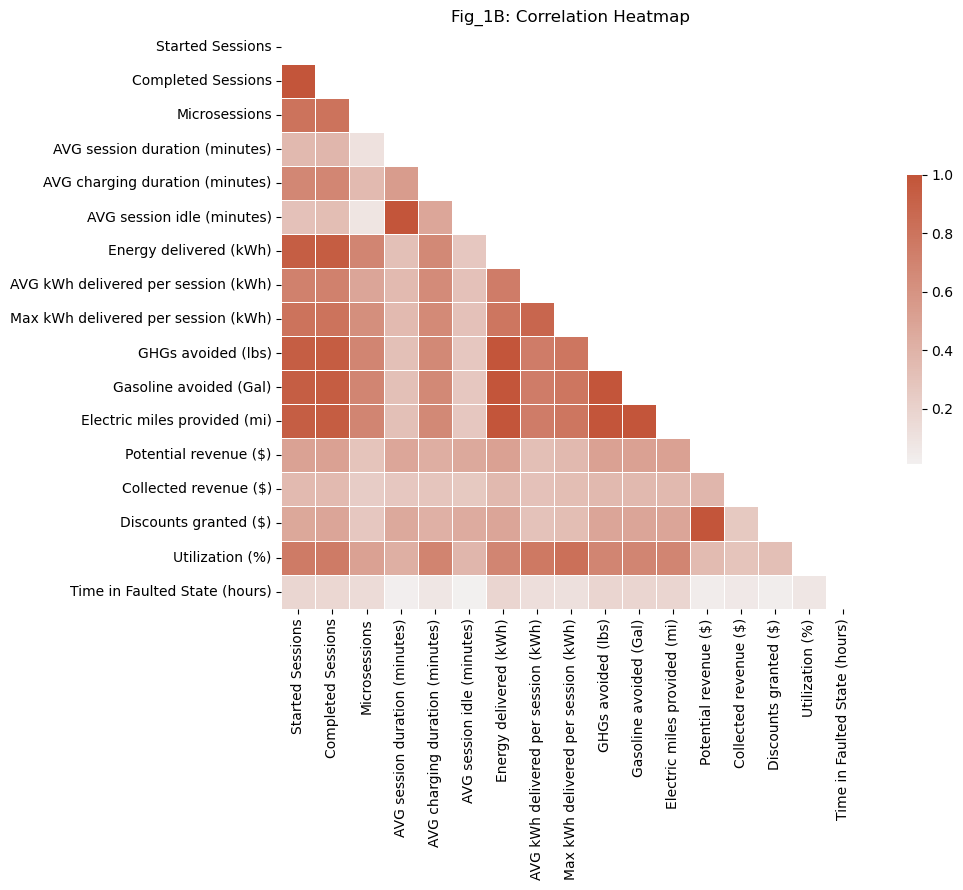

In [82]:
# Get correlations between the features 
df_reporting_corr = df_reporting.corr()
# print(df_reporting_corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_reporting_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_reporting_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Fig_1B: Correlation Heatmap')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/days/fig1B.jpg')

# Show the plot
plt.show()

In [83]:
# Top Correlations

# NOTE: I don't think this is useful as is but might be helpful if we want to filter down to some more useful correlations.

# Convert correlation matrix to a series for easier manipulation
corr_pairs = df_reporting_corr.unstack()

# Remove self-correlations (which are always 1)
corr_pairs = corr_pairs[corr_pairs < 1]

# Get absolute values for sorting (to include negative correlations)
corr_pairs_abs = corr_pairs.abs().sort_values(ascending=False)

# Get top 5 correlations (these will be the strongest positive and negative)
top_5_correlations = corr_pairs_abs.head(5)

# Display the results with their actual correlation values (not absolute)
for idx, (pair, _) in enumerate(top_5_correlations.items(), 1):
    feature1, feature2 = pair
    correlation = corr_pairs[pair]
    print(f"{idx}. {feature1} — {feature2}: {correlation:.4f}")

1. Energy delivered (kWh) — GHGs avoided (lbs): 1.0000
2. GHGs avoided (lbs) — Energy delivered (kWh): 1.0000
3. Gasoline avoided (Gal) — GHGs avoided (lbs): 1.0000
4. GHGs avoided (lbs) — Gasoline avoided (Gal): 1.0000
5. GHGs avoided (lbs) — Electric miles provided (mi): 1.0000


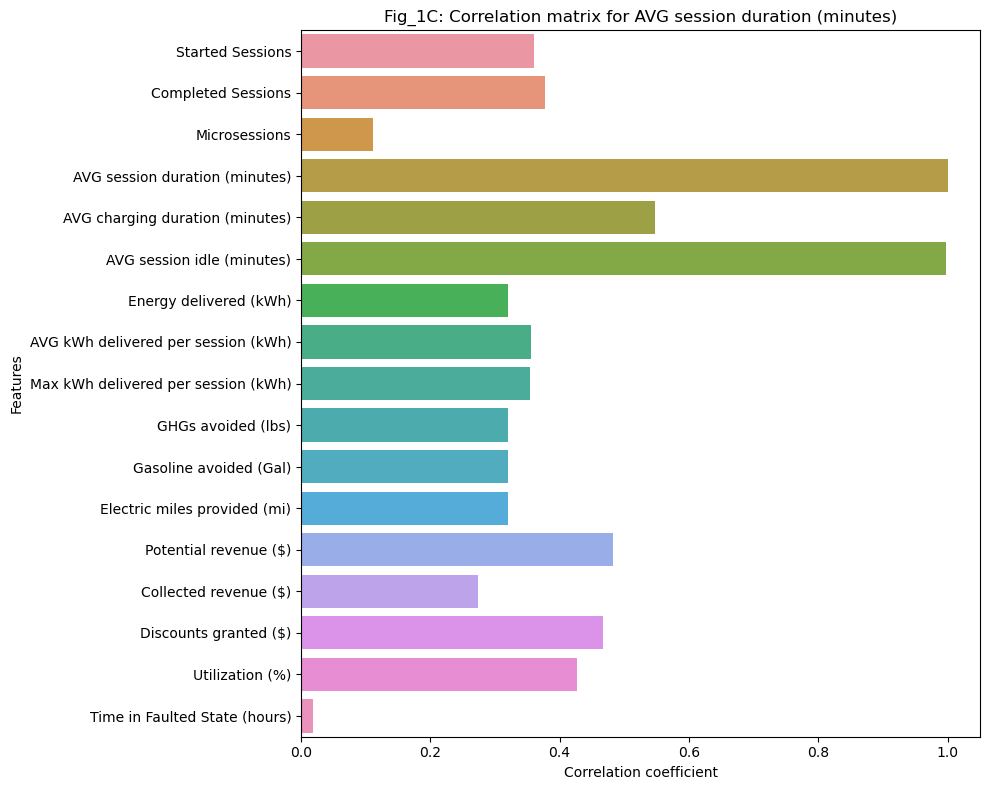

In [84]:
# Fig_1C: Correlation matrix for AVG session duration (minutes)

# Get correlations between the features 
df_reporting_corr = df_reporting.corr()

# Get correlation matrix for AVG session duration (minutes)
df_reporting_corr_avg_sessions = df_reporting_corr['AVG session duration (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=df_reporting_corr_avg_sessions.values, y=df_reporting_corr_avg_sessions.index)
plt.title('Fig_1C: Correlation matrix for AVG session duration (minutes)')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/days/fig1C.jpg')

# Show the plot
plt.show()

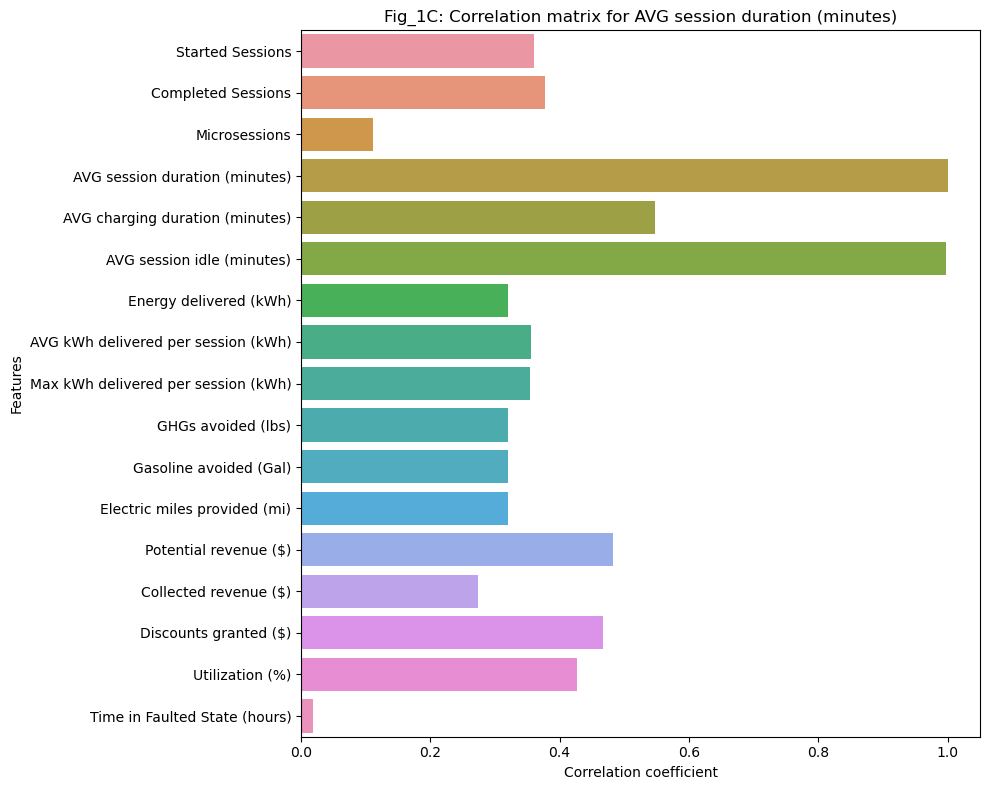

In [85]:
# Fig_1C: Correlation matrix for AVG session duration (minutes)

# Get correlations between the features 
df_reporting_corr = df_reporting.corr()

# Get correlation matrix for AVG session duration (minutes)
df_reporting_corr_avg_sessions = df_reporting_corr['AVG session duration (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=df_reporting_corr_avg_sessions.values, y=df_reporting_corr_avg_sessions.index)
plt.title('Fig_1C: Correlation matrix for AVG session duration (minutes)')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/days/fig1C.jpg')

# Show the plot
plt.show()

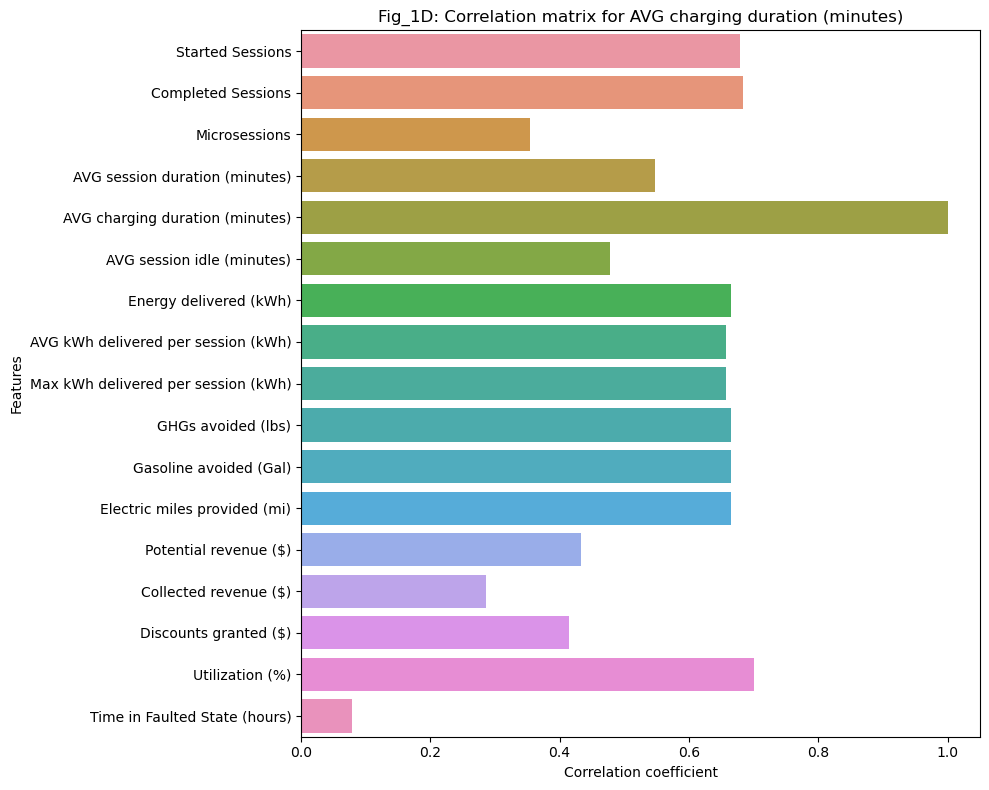

In [86]:
# Fig_1D: Correlation matrix for AVG charging duration (minutes)

# Get correlations between the features 
df_reporting_corr = df_reporting.corr()

# Get correlation matrix for AVG session duration (minutes)
df_reporting_corr_avg_duration = df_reporting_corr['AVG charging duration (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=df_reporting_corr_avg_duration.values, y=df_reporting_corr_avg_duration.index)
plt.title('Fig_1D: Correlation matrix for AVG charging duration (minutes)')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/days/fig1D.jpg')

# Show the plot
plt.show()

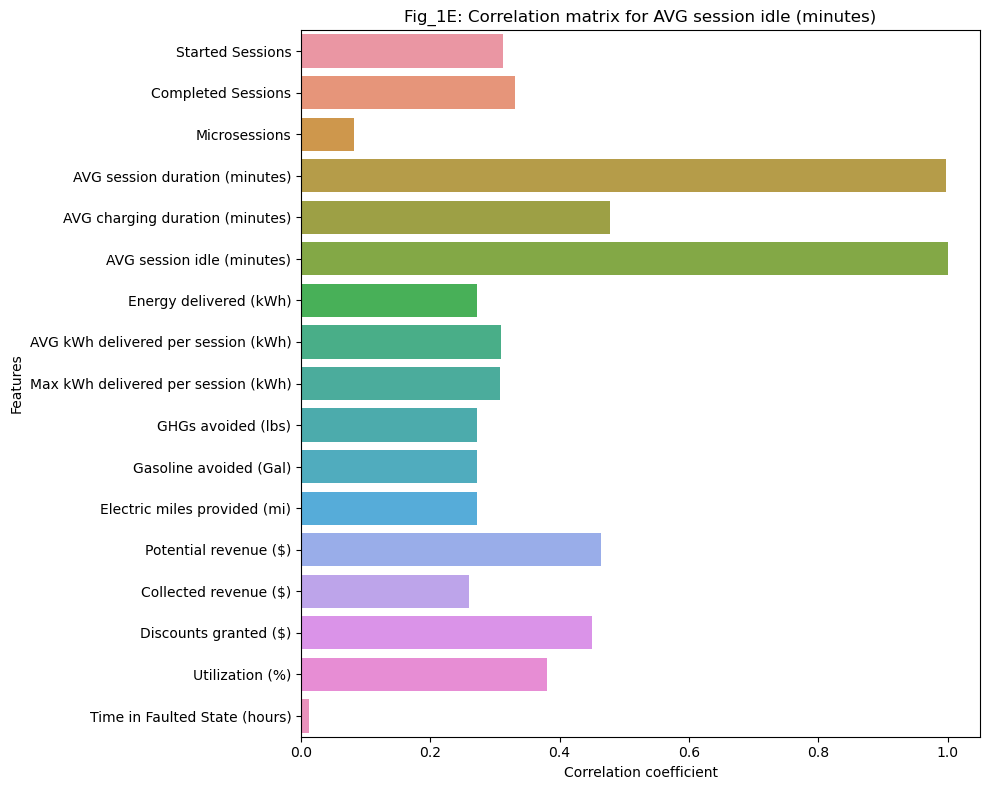

In [87]:
# Fig_1E: Correlation matrix for AVG session idle (minutes)

# Get correlations between the features 
df_reporting_corr = df_reporting.corr()

# Get correlation matrix for AVG session duration (minutes)
df_reporting_corr_avg_idle = df_reporting_corr['AVG session idle (minutes)']

# Seaborn plot for correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=df_reporting_corr_avg_idle.values, y=df_reporting_corr_avg_idle.index)
plt.title('Fig_1E: Correlation matrix for AVG session idle (minutes)')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

# Adjust layout to prevent labels from being cropped off
plt.tight_layout()

# Save plot
plt.savefig('images/days/fig1E.jpg')

# Show the plot
plt.show()

###  Analysing Daily Reports Dataset 

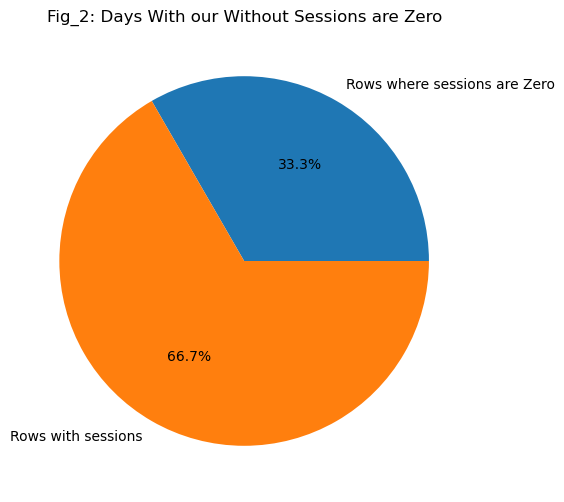

Rows where sessions are Zero 609. Rows with sessions 1218.


In [88]:
# Gets the number of started sessions = 0 and compared to non-zero values. Later in the timeline report we see this changes with time.
count_w_zero_sessions = len(df_reporting[df_reporting["Started Sessions"] == 0])
count_w_sessions = len(df_reporting[df_reporting["Started Sessions"] > 0])
data = [count_w_zero_sessions, count_w_sessions]
# Create the bar plot with Seaborn
plt.figure(figsize=(12, 6))
fig1 = plt.pie(data, labels=['Rows where sessions are Zero', 'Rows with sessions'],autopct='%1.1f%%')

# Customize the plot
plt.title('Fig_2: Days With our Without Sessions are Zero')

# Save the plot
plt.savefig('images/days/fig2.jpg')

# Show the plot
plt.show()
print(f"Rows where sessions are Zero {count_w_zero_sessions}. Rows with sessions {count_w_sessions}.")


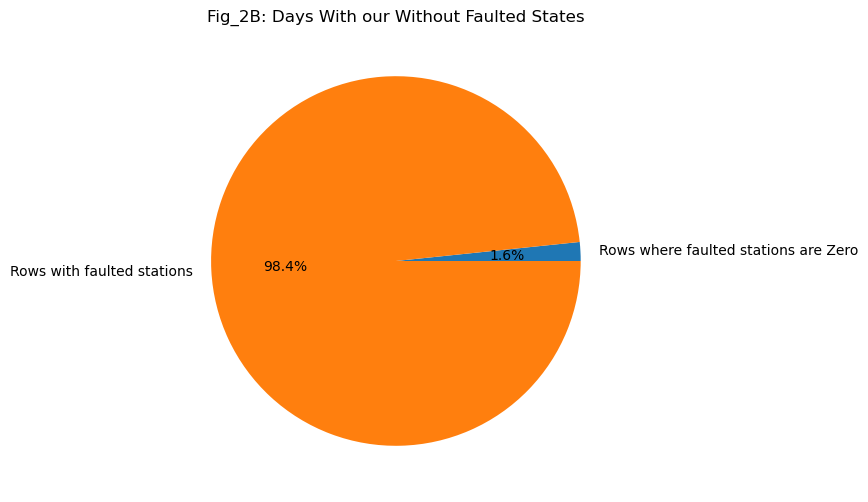

Rows where faulted stations are Zero 6. Rows with faulted stations 359.


In [89]:
# Gets the mean of missing values in each column. Since True = 1 and False = 0 the mean tells us how much of the data is missing.
count_w_zero_faulted_stations = len(df_reporting_2024[df_reporting_2024["Faulted Stations"] == "-"])
count_w_faulted_stations = len(df_reporting_2024[df_reporting_2024["Faulted Stations"] != "-"])
data = [count_w_zero_faulted_stations, count_w_faulted_stations ]
# Create the bar plot with Seaborn
plt.figure(figsize=(12, 6))
fig1 = plt.pie(data, labels=['Rows where faulted stations are Zero', 'Rows with faulted stations'],autopct='%1.1f%%')

# Customize the plot
plt.title('Fig_2B: Days With our Without Faulted States')

# Save the plot
plt.savefig('images/days/fig2B.jpg')

# Show the plot
plt.show()
print(f"Rows where faulted stations are Zero {count_w_zero_faulted_stations}. Rows with faulted stations {count_w_faulted_stations}.")

### Structuring the Data as Time Series

In [107]:
# Convert Dataframe to timeline
df_reporting_timeline = df_reporting.copy()
df_reporting_timeline['Day'] = pd.to_datetime(df_reporting_timeline['Day'])
df_reporting_timeline = df_reporting_timeline.set_index('Day')

# Convert Dataframe to timeline 2024 
df_reporting_timeline_2024 = df_reporting_2024.copy()
df_reporting_timeline_2024['Day'] = pd.to_datetime(df_reporting_timeline_2024['Day'])
df_reporting_timeline_2024 = df_reporting_timeline_2024.set_index('Day')

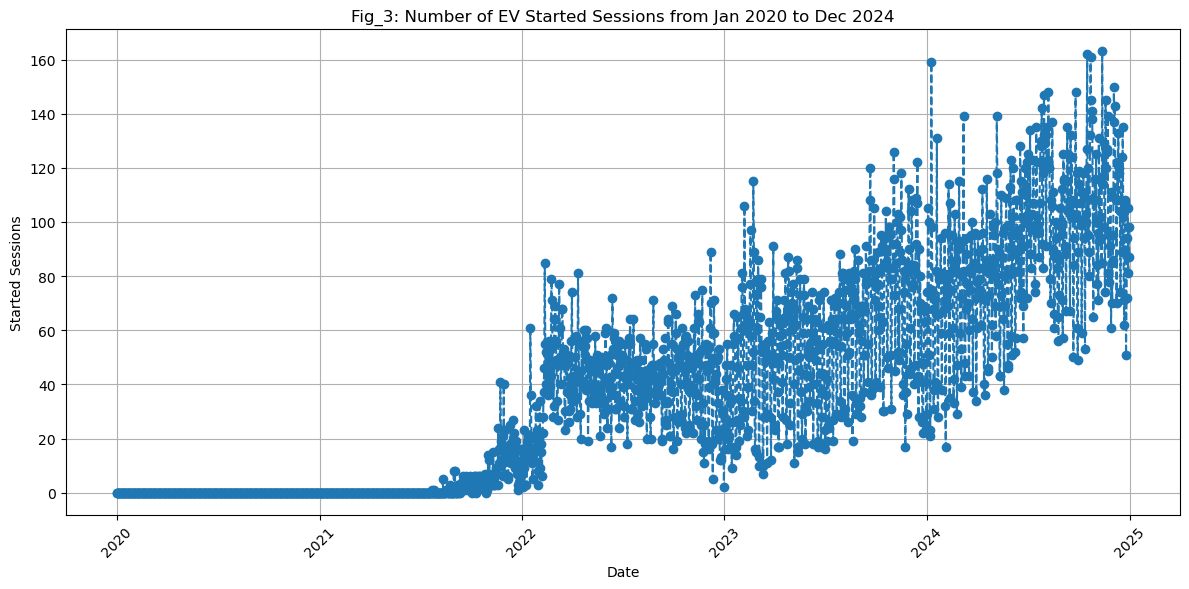

In [108]:
# Plot the timeline of started sessions
plt.figure(figsize=(12, 6))
plt.plot(df_reporting_timeline.index, df_reporting_timeline['Started Sessions'], '--o')
plt.title('Fig_3: Number of EV Started Sessions from Jan 2020 to Dec 2024')
plt.xlabel('Date')
plt.ylabel('Started Sessions')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.savefig('images/days/fig3.jpg')
plt.show()

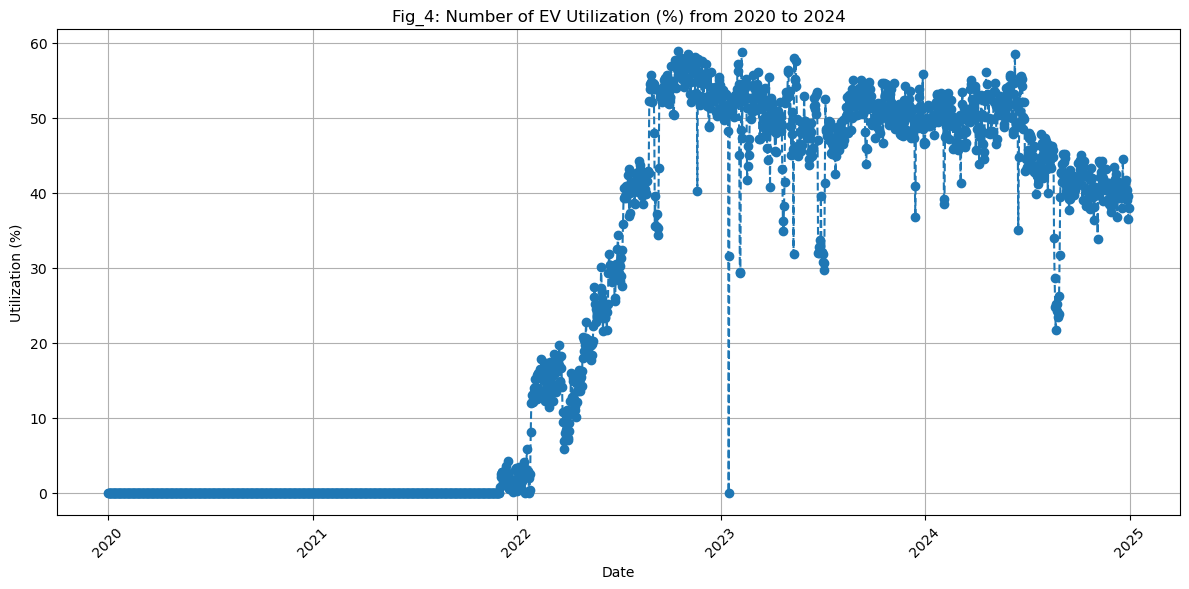

In [109]:
# Plot the timeline of started sessions
plt.figure(figsize=(12, 6))
plt.plot(df_reporting_timeline.index, df_reporting_timeline['Utilization (%)'], '--o')
plt.title('Fig_4: Number of EV Utilization (%) from 2020 to 2024')
plt.xlabel('Date')
plt.ylabel('Utilization (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.savefig('images/days/fig4.jpg')
plt.show()

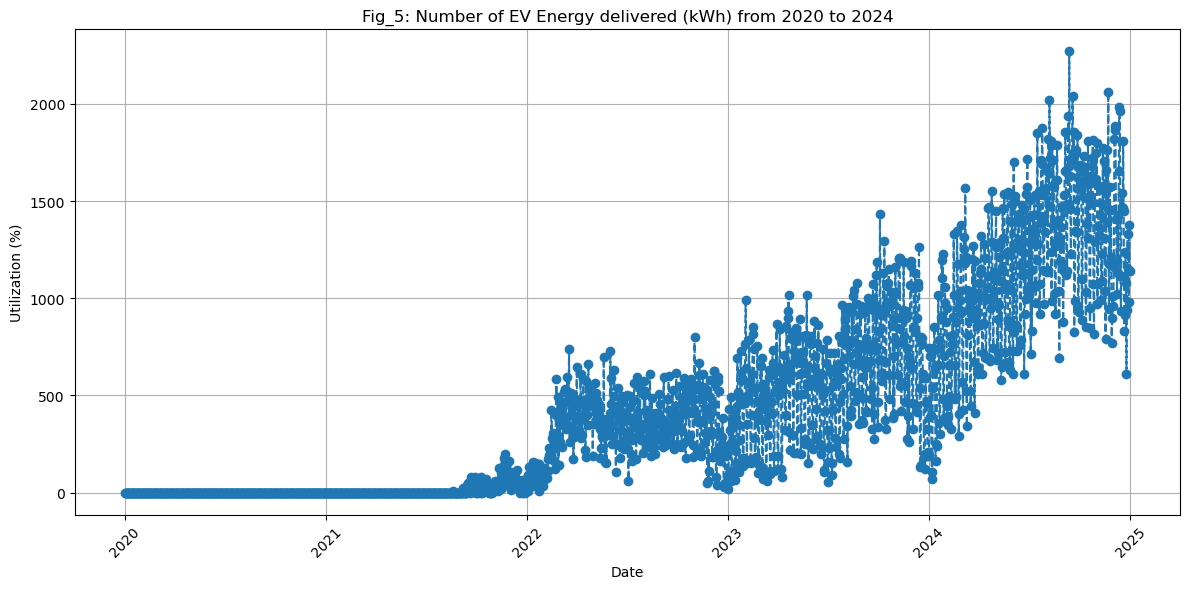

In [110]:
# Plot the timeline of Energy delivered (kWh)
plt.figure(figsize=(12, 6))
plt.plot(df_reporting_timeline.index, df_reporting_timeline['Energy delivered (kWh)'], '--o')
plt.title('Fig_5: Number of EV Energy delivered (kWh) from 2020 to 2024')
plt.xlabel('Date')
plt.ylabel('Utilization (%)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.savefig('images/days/fig5.jpg')
plt.show()

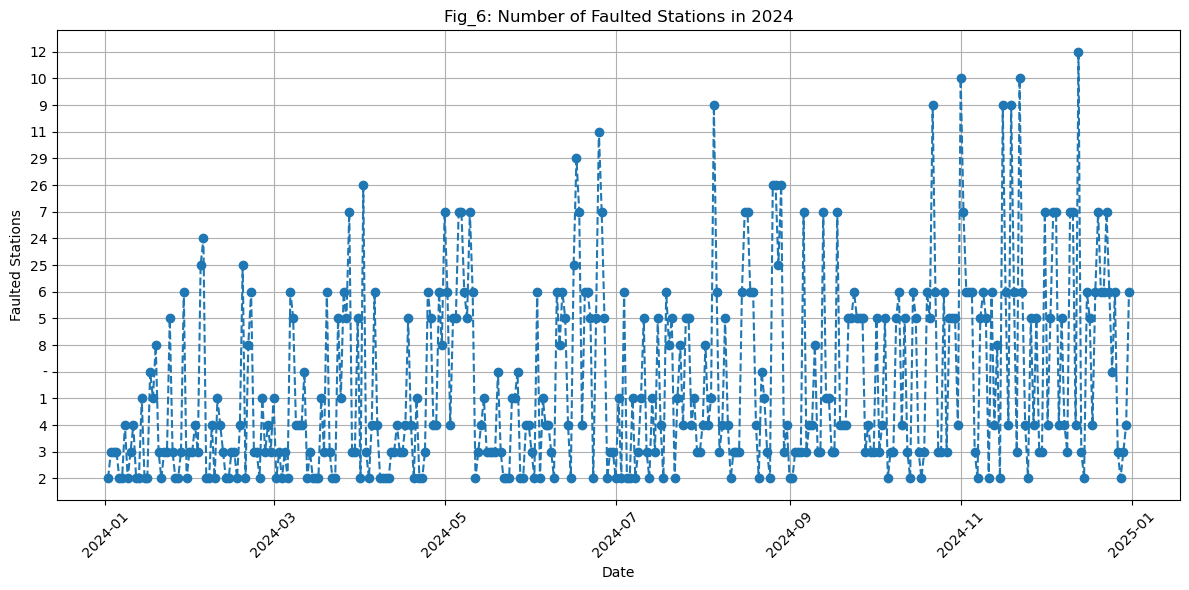

In [111]:
# Plot the timeline of faulted stations for 2024 (data was not previously available due to infrastructure software changes)
plt.figure(figsize=(12, 6))
plt.plot(df_reporting_timeline_2024.index, df_reporting_timeline_2024['Faulted Stations'], '--o')
plt.title('Fig_6: Number of Faulted Stations in 2024')
plt.xlabel('Date')
plt.ylabel('Faulted Stations')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.savefig('images/days/fig6.jpg')
plt.show()

### Modeling

To help us forecast the EV charging infrastructure capacity needs for the CSB we will forecast the energy needs trends based on the data for 2022 through 2024. As we saw in the line plot "Fig_5: Number of EV Energy delivered (kWh) from 2020 to 2024" the energy utilization is minimal until 2022 calendar year.

In [112]:
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [114]:
energy_df = df_reporting_timeline['Energy delivered (kWh)']['2022-01-01':]
energy_df.head()

Day
2022-01-01     11.816001
2022-01-02      6.418000
2022-01-03     88.642230
2022-01-04     67.513000
2022-01-05    132.095400
Name: Energy delivered (kWh), dtype: float64

### Split data into train and test splits 

In [119]:

# Calculate the 70% split point
split_point = int(len(energy_df) * 0.7)

# Create the train and test sets
X_train = energy_df.iloc[:split_point]
X_test = energy_df.iloc[split_point:]

### Perform Adfuller Test of Stationarity 

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or not. Here's what the ADF test values mean:

Purpose: The test checks for the presence of a unit root in the time series, which indicates non-stationarity.
Null Hypothesis: The series has a unit root (is non-stationary).
Alternative Hypothesis: The series does not have a unit root (is stationary).
Interpretation of results:

ADF Statistic: More negative values indicate stronger evidence for stationarity.
p-value:

p < 0.05: Reject null hypothesis → Series is stationary

p > 0.05: Fail to reject null hypothesis → Series is non-stationary


Critical Values: The ADF statistic must be more negative than these values to reject the null hypothesis at the respective significance levels.

In [120]:
# Perform the Adfuller test
result = adfuller(X_train)

# Extract and print the results
adf_statistic, p_value, used_lag, n_obs, critical_values, ic_best = result
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Critical Values: {critical_values}')

ADF Statistic: -2.4380715161615587
p-value: 0.1312779855519529
Critical Values: {'1%': -3.439146171679794, '5%': -2.865422101274577, '10%': -2.568837245865348}


##### Interpretation:

ADF Statistic (-2.438): The data is not yet stationary.
p-value (0.131): This means we still fail to reject the null hypothesis of a unit root.
Critical Values: Your ADF statistic (-2.438) is:

    Less negative than the 1% critical value (-3.439)
    Less negative than the 5% critical value (-2.865)
    But more negative than the 10% critical value (-2.569), though just barely

##### Takeaway: Differencing might be required.

### Plotting Autocorrelation and Partial Autocorrelation

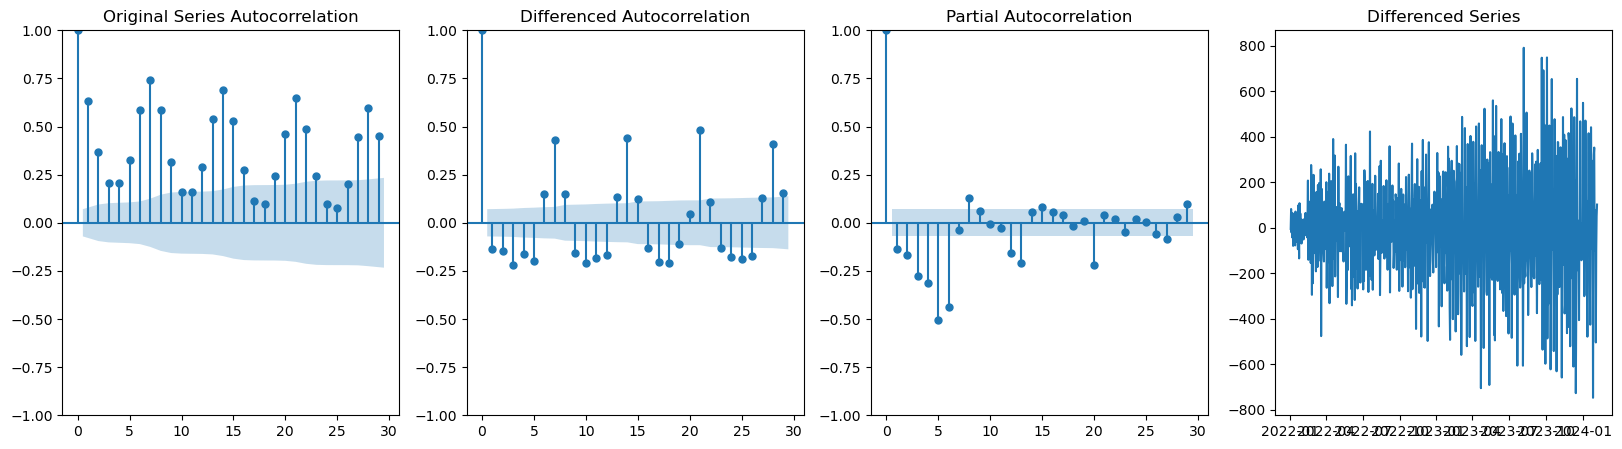

In [126]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
plot_acf(X_train, ax = ax[0]);
ax[0].set_title('Original Series Autocorrelation')
plot_acf(X_train.diff().dropna(), ax = ax[1]);
ax[1].set_title('Differenced Autocorrelation')
plot_pacf(X_train.diff().dropna(), ax = ax[2], method = 'ywm');
ax[3].plot(X_train.diff().dropna())
ax[3].set_title('Differenced Series');

Original Series Autocorrelation (first panel):
This shows significant autocorrelation at multiple lags, with many spikes exceeding the confidence intervals (blue shaded area). The presence of many significant lags that decay slowly indicates your original series is non-stationary, confirming what the ADF test suggested.
Differenced Autocorrelation (second panel):
After applying first differencing, the autocorrelation structure is much improved. While there are still some significant lags, they're fewer and don't show the systematic pattern seen in the original series. This suggests differencing has helped address the non-stationarity.
Partial Autocorrelation (third panel):
The PACF of the differenced series shows a significant spike at lag 1 (and a few other scattered significant lags). This pattern is typical of an AR process, suggesting your differenced series might be modeled with an autoregressive component.
Differenced Series (fourth panel):
This shows the actual plot of the differenced data over time. The variation appears more consistent throughout the series compared to what would be expected in the original data. However, there's still some visible pattern in the volatility (the amplitude of fluctuations seems to increase over time), which might indicate conditional heteroskedasticity.

Overall, these plots suggest:

The data was clearly non-stationary
First-order differencing has significantly improved stationarity
The differenced series might be appropriately modeled with an ARIMA model, likely with an AR component

### ARIMA Model with Differenced Applied

In [134]:
# Apply first-order differencing
X_train_diff = X_train.diff().dropna()

# Based on the ACF and PACF plots, we will fit an ARIMA model
# Using (p,d,q) = (1,1,0) as a starting point
# p=1 because the PACF showed significant lag at 1
# d=1 because we're already using first differencing 
# q=0 as a starting point (can be adjusted based on results)

# Fit the ARIMA model
model = ARIMA(X_train, order=(1, 1, 0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Energy delivered (kWh)   No. Observations:                  767
Model:                     ARIMA(1, 1, 0)   Log Likelihood               -5246.512
Date:                    Tue, 15 Apr 2025   AIC                          10497.024
Time:                            23:22:38   BIC                          10506.306
Sample:                        01-01-2022   HQIC                         10500.597
                             - 02-06-2024                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1368      0.039     -3.479      0.001      -0.214      -0.060
sigma2      5.215e+04   2308.177     22.593      0.000    4.76e+04    5.67e+04
Ljung-Box (L1) (Q): 

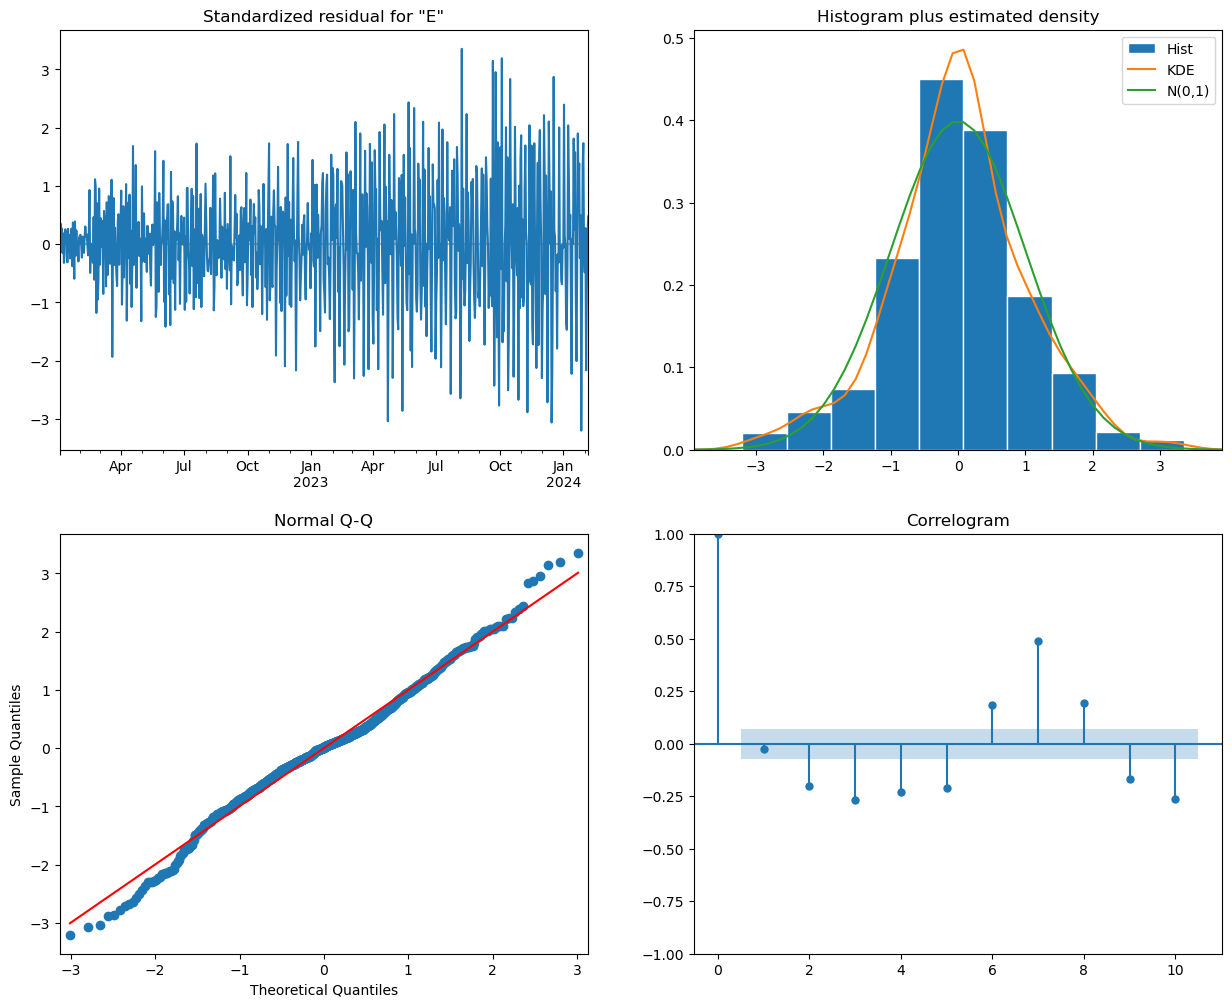

In [135]:
# Plot diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

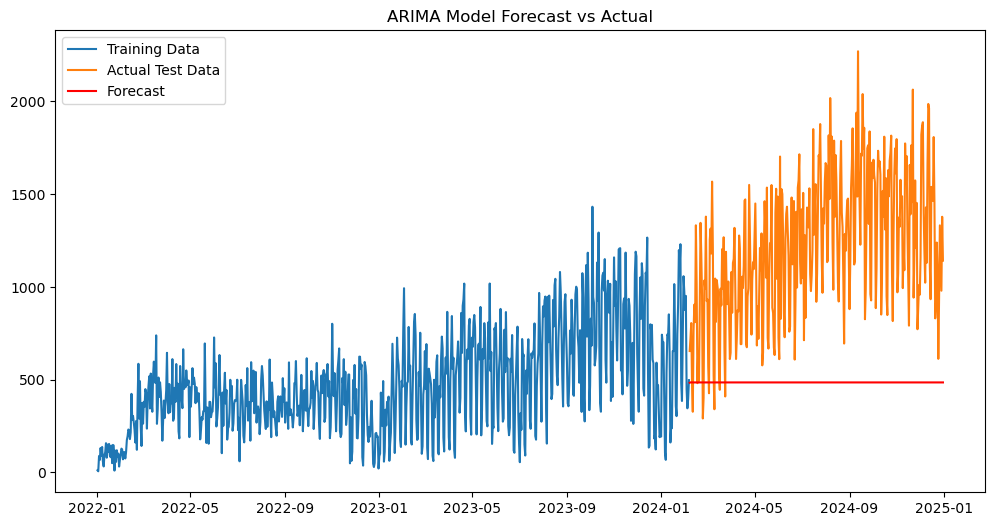

Mean Squared Error (MSE): 679678.87
Root Mean Squared Error (RMSE): 824.43
Mean Absolute Error (MAE): 736.63
Mean Absolute Percentage Error (MAPE): 56.09%


In [137]:
# Forecast
forecast_steps = len(X_test)
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the forecast against actual values
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, X_train, label='Training Data')
plt.plot(X_test.index, X_test, label='Actual Test Data')
plt.plot(X_test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Model Forecast vs Actual')
plt.show()

# Calculate forecast error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# MSE and RMSE
mse = mean_squared_error(X_test, forecast)
rmse = np.sqrt(mse)
# MAE
mae = mean_absolute_error(X_test, forecast)
# MAPE
mape = np.mean(np.abs((X_test - forecast) / X_test)) * 100

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')